In [2]:
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import numpy as np
import string
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler 
warnings.filterwarnings('ignore', category=DeprecationWarning)
import pickle



# Data Preparation

## Merging Dataframes

In [3]:
df1 = pd.read_csv('malicious_phish.csv')
df2 = pd.read_csv("Benign_list_big_final.csv",header=None)
df3 = pd.read_csv("DefacementSitesURLFiltered.csv",header=None)
df4 = pd.read_csv("Malware_dataset.csv",header=None)
df5 = pd.read_csv("phishing_dataset.csv",header=None)
df6 = pd.read_csv("spam_dataset.csv",header=None)





In [4]:
unique_values = df1['type'].unique()
unique_values

array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

In [5]:
df2 = df2.rename(columns={0: "url"})
df3 = df3.rename(columns={0: "url"})
df4 = df4.rename(columns={0: "url"})
df5 = df5.rename(columns={0: "url"})
df6 = df6.rename(columns={0: "url"}) 

In [6]:
df2["type"]="benign"
df3["type"]="defacement"
df4["type"]="malware"
df5["type"]="phishing"
df6["type"]="spam"

print("df1",df1.shape)
print("df2",df2.shape)
print("df3",df3.shape)
print("df4",df4.shape)
print("df5",df5.shape)
print("df6",df6.shape)

print(df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0] + df5.shape[0] + df6.shape[0] ) 

df1 (651191, 2)
df2 (35378, 2)
df3 (96457, 2)
df4 (11566, 2)
df5 (9965, 2)
df6 (12000, 2)
816557


In [7]:
df = pd.concat([df1, df2, df3, df4, df5 ,df6])
df.shape

(816557, 2)

## Data Preprocessing

### Count nan values

In [8]:
total_nan_count = df.isnull().sum().sum()
print(total_nan_count)

# No missing values

0


### Remove Duplicates

In [9]:
df = df.drop_duplicates(subset=['url'])
df.shape

# 816557 - 653040 = 163517 values dropped due to duplication

(653040, 2)

### Label Encoding 

In [10]:
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])
df.head(2)


c:\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,url,type,type_encoded
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0


## Balancing Dataset

#### Dropping values more than 30000 and using randomly sampling to increase samples less that 30000

In [11]:
value_counts = df['type'].value_counts()

print("Value counts:",value_counts)


Value counts: type
benign        428080
defacement     95308
phishing       94086
malware        23645
spam           11921
Name: count, dtype: int64


In [12]:
n_samples = 30000
class_subset = df[df['type'] == 'benign']
benign = class_subset.sample(n = n_samples, random_state=42)

class_subset = df[df['type'] == 'defacement']
defacement = class_subset.sample(n = n_samples, random_state=42)

class_subset = df[df['type'] == 'phishing']
phishing = class_subset.sample(n = n_samples, random_state=42)

class_subset = df[df['type'] == 'malware']
current_samples = class_subset.shape[0]

if current_samples < n_samples:
    additional_samples_required = n_samples - current_samples
    additional_samples = class_subset.sample(n=additional_samples_required, replace=True, random_state=42)
    malware = pd.concat([class_subset, additional_samples])



class_subset = df[df['type'] == 'spam']
current_samples = class_subset.shape[0]

if current_samples < n_samples:
    additional_samples_required = n_samples - current_samples
    additional_samples = class_subset.sample(n=additional_samples_required, replace=True, random_state=42)
    spam = pd.concat([class_subset, additional_samples])
    





In [13]:
df = pd.concat([benign, defacement, phishing, malware, spam])
df.shape

(150000, 3)

## Exploratory Data Analysis (EDA)

### Counting the length of URLs

In [14]:
df['URL_Length'] = df['url'].apply(lambda x: len(str(x)))
average_length_per_type = df.groupby('type')['URL_Length'].mean()
average_length_dict = average_length_per_type.to_dict()
average_length_dict

{'benign': 57.919,
 'defacement': 86.20473333333334,
 'malware': 46.644666666666666,
 'phishing': 45.8942,
 'spam': 128.3842}

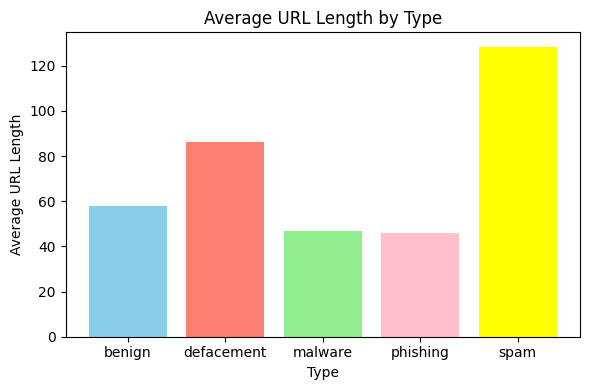

In [15]:
# Create a bar plot using Matplotlib
plt.figure(figsize=(6, 4))  # Adjust the figure size if needed
plt.bar(average_length_dict.keys(), average_length_dict.values(), color= ['skyblue', 'salmon', 'lightgreen', 'pink' ,'yellow'])

plt.xlabel('Type')
plt.ylabel('Average URL Length')
plt.title('Average URL Length by Type')

plt.xticks()  # Rotate x-axis labels if needed

plt.tight_layout()
plt.show()

### Number of Unique Domains

Domain Statistics:
            count  nunique            <lambda_0>
type                                            
benign      30000      224                      
defacement  30000     1930          www.sgeo.net
malware     30000     7005  mitsui-jyuku.mixh.jp
phishing    30000     5327                      
spam        30000      199       adservers.co.uk


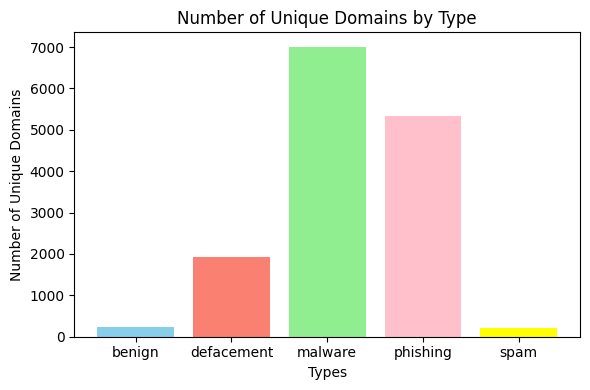

In [16]:
# Function to extract domain names from URLs
def extract_domain(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc

# Apply the function to create a new column 'Domain'
df['Domain'] = df['url'].apply(extract_domain)

# Group by 'type' and analyze domain statistics
domain_stats = df.groupby('type')['Domain'].agg(['count', 'nunique', lambda x: x.value_counts().idxmax()])

print("Domain Statistics:")
print(domain_stats)

# Plotting the bar graph for 'nunique' values by 'type'
plt.figure(figsize=(6, 4))  # Adjust the figure size if needed

types = domain_stats.index
nunique_values = domain_stats['nunique']

plt.bar(types, nunique_values, color= ['skyblue', 'salmon', 'lightgreen', 'pink' ,'yellow'])
plt.xlabel('Types')
plt.ylabel('Number of Unique Domains')
plt.title('Number of Unique Domains by Type')
plt.xticks()
plt.tight_layout()

plt.show()

### Count of Numbers , Characters , Special Characters and Symbols

In [17]:
# Function to count special characters, characters, numbers, and symbols
def count_chars(row):
    special_chars = sum(1 for char in row if char in string.punctuation)
    symbols = sum(1 for char in row if char in string.printable and char not in string.ascii_letters and char not in string.digits)
    chars = sum(1 for char in row if char.isalpha())
    numbers = sum(1 for char in row if char.isdigit())
    return pd.Series([special_chars, symbols, chars, numbers], index=['SpecialChars', 'Symbols', 'Chars', 'Numbers'])

# Apply the function to each row and append counts in new columns
df[['SpecialChars', 'Symbols', 'Chars', 'Numbers']] = df['url'].apply(count_chars)

C:\Users\Aeiman Imtiaz\AppData\Local\Temp\ipykernel_13112\3854592704.py:10: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df[['SpecialChars', 'Symbols', 'Chars', 'Numbers']] = df['url'].apply(count_chars)


In [18]:
df

,url,type,type_encoded,URL_Length,Domain,SpecialChars,Symbols,Chars,Numbers
343443,cybermuse.gallery.ca/cybermuse/search/artist_e...,benign,0,65,,9,9,52,4
193033,fanpix.net/gallery/paul-gleason-pictures.htm,benign,0,44,,6,6,38,0
376188,biogs.com/strictlycomedancing/bellingham.html,benign,0,45,,4,4,41,0
212737,mylife.com/c-1090135275,benign,0,23,,3,3,10,10
246981,mcshane-construction.com/leadership.aspx,benign,0,40,,4,4,36,0
...,...,...,...,...,...,...,...,...,...
414,http://archive.thisisyork.co.uk/2000/7/7/31515...,spam,4,52,archive.thisisyork.co.uk,11,11,29,12
1559,http://archive.thisisoxfordshire.co.uk/2005/11...,spam,4,60,archive.thisisoxfordshire.co.uk,11,11,36,13
4555,http://acard4u.co.uk/product_reviews_write.php...,spam,4,70,acard4u.co.uk,14,14,52,4
7184,http://archives.li.man.ac.uk/ead/search/?opera...,spam,4,213,archives.li.man.ac.uk,35,35,146,32


In [19]:
average_SpecialChars_per_type = df.groupby('type')['SpecialChars'].mean()
average_SpecialChars = average_SpecialChars_per_type.to_dict()
average_SpecialChars

{'benign': 8.559366666666667,
 'defacement': 14.858766666666666,
 'malware': 9.395566666666667,
 'phishing': 6.6573,
 'spam': 16.373466666666666}

In [20]:
average_Symbols_per_type = df.groupby('type')['Symbols'].mean()
average_Symbols = average_Symbols_per_type.to_dict()
average_Symbols

{'benign': 8.559833333333334,
 'defacement': 14.858766666666666,
 'malware': 9.395566666666667,
 'phishing': 6.660533333333333,
 'spam': 16.373466666666666}

In [21]:
average_Chars_per_type = df.groupby('type')['Chars'].mean()
average_Chars = average_Chars_per_type.to_dict()
average_Chars

{'benign': 43.626133333333335,
 'defacement': 66.77503333333334,
 'malware': 26.203333333333333,
 'phishing': 35.4675,
 'spam': 89.9678}

In [22]:
average_numbers_per_type = df.groupby('type')['Numbers'].mean()
average_numbers = average_numbers_per_type.to_dict()
average_numbers

{'benign': 5.732766666666667,
 'defacement': 4.5701,
 'malware': 11.045766666666667,
 'phishing': 3.7358666666666664,
 'spam': 22.042933333333334}

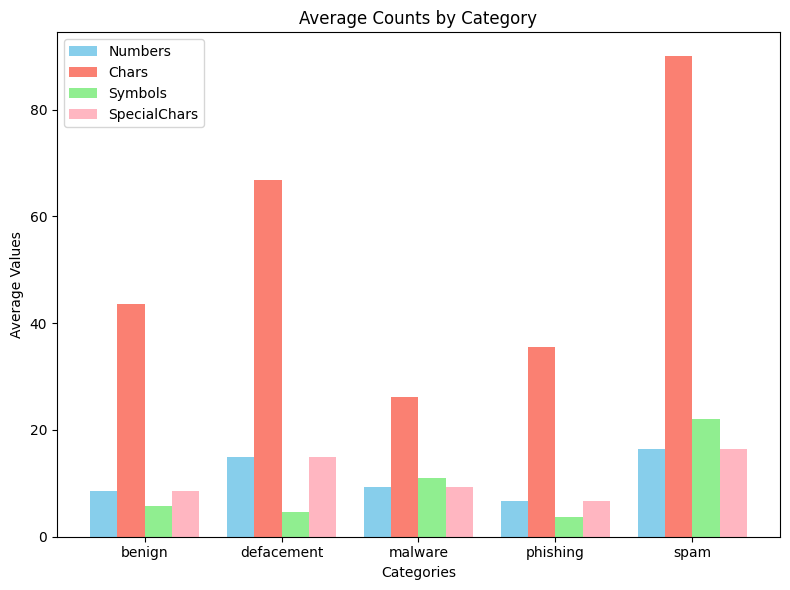

In [23]:
import numpy as np
categories = ['benign', 'defacement', 'malware', 'phishing', 'spam']
bar_width = 0.2
index = np.arange(len(categories))

plt.figure(figsize=(8, 6))

plt.bar(index - 1.5 * bar_width, list(average_Symbols.values()), bar_width, label='Numbers', color='skyblue')
plt.bar(index - 0.5 * bar_width, list(average_Chars.values()), bar_width, label='Chars', color='salmon')
plt.bar(index + 0.5 * bar_width, list(average_numbers.values()), bar_width, label='Symbols', color='lightgreen')
plt.bar(index + 1.5 * bar_width, list(average_SpecialChars.values()), bar_width, label='SpecialChars', color='lightpink')

plt.xlabel('Categories')
plt.ylabel('Average Values')
plt.title('Average Counts by Category')
plt.xticks(index, categories)
plt.legend()
plt.tight_layout()

plt.show()

### Subdomains count and Path Depth

In [24]:
def analyze_url(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            subdomains = parsed_url.hostname.split('.')
            path = parsed_url.path.split('/')
            return len(subdomains), len(path)
    except:
        pass
    return None, None

df[['Subdomains_Count', 'Path_Depth']] = pd.DataFrame(df['url'].apply(analyze_url).tolist(), columns=['Subdomains_Count', 'Path_Depth'])

url_structure_stats = df.groupby('type')[['Subdomains_Count', 'Path_Depth']].mean().to_dict()

print("Structure and Depth of URLs for Different Categories:")
print(url_structure_stats)

Structure and Depth of URLs for Different Categories:
{'Subdomains_Count': {'benign': 3.2346379647749512, 'defacement': 3.2350548284400427, 'malware': 3.161681487469685, 'phishing': 3.240809802876931, 'spam': 2.098047192839707}, 'Path_Depth': {'benign': 3.3465753424657536, 'defacement': 3.3786699681641315, 'malware': 3.3257881972514145, 'phishing': 3.3388385721896645, 'spam': 4.547192839707079}}


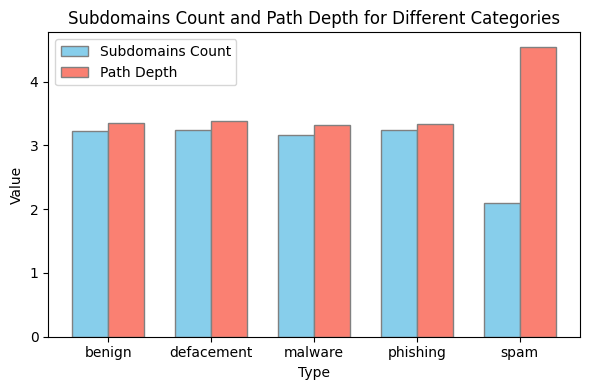

In [25]:
# Extract categories and corresponding values
categories = list(url_structure_stats['Subdomains_Count'].keys())
subdomains_count = list(url_structure_stats['Subdomains_Count'].values())
path_depth = list(url_structure_stats['Path_Depth'].values())

# Set the bar width
bar_width = 0.35

# Set the positions of bars on the x-axis
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar chart
plt.figure(figsize=(6, 4))

plt.bar(r1, subdomains_count, color='skyblue', width=bar_width, edgecolor='grey', label='Subdomains Count')
plt.bar(r2, path_depth, color='salmon', width=bar_width, edgecolor='grey', label='Path Depth')

plt.xlabel('Type')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories)
plt.ylabel('Value')
plt.title('Subdomains Count and Path Depth for Different Categories')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
def count_top_words(url_series):
    # Combine all URLs of a specific type into one string
    text = ' '.join(url_series)
    
    # Extract words/terms (you may modify the regex pattern based on your requirements)
    words = re.findall(r'\b\w+\b', text.lower())
    
    # Count the occurrences of each word/term
    word_counts = Counter(words)
    
    # Return the top 5 most common words/terms
    return word_counts.most_common(10)

# Group by 'type' and apply the function to count top words/terms for each type
top_words_by_type = df.groupby('type')['url'].apply(count_top_words).reset_index().to_dict()

print(top_words_by_type)

{'type': {0: 'benign', 1: 'defacement', 2: 'malware', 3: 'phishing', 4: 'spam'}, 'url': {0: [('com', 22905), ('html', 4858), ('org', 2688), ('http', 2527), ('net', 2051), ('php', 1951), ('en', 1896), ('htm', 1866), ('d8', 1495), ('amp', 1347)], 1: [('http', 30015), ('www', 20949), ('index', 17909), ('php', 15992), ('option', 12431), ('com', 12278), ('itemid', 10705), ('view', 9829), ('id', 9214), ('html', 8558)], 2: [('http', 20065), ('https', 8561), ('com', 8407), ('exe', 7635), ('m', 5468), ('mozi', 5289), ('uploads', 3729), ('jp', 3689), ('mixh', 3650), ('mitsui', 3648)], 3: [('com', 18026), ('www', 11976), ('http', 6077), ('html', 5902), ('org', 3141), ('https', 2485), ('net', 2456), ('amp', 2249), ('htm', 2150), ('php', 1981)], 4: [('uk', 30313), ('http', 30303), ('co', 22238), ('html', 9188), ('php', 8038), ('archive', 7973), ('ac', 6178), ('1', 5049), ('csp', 4072), ('cpath', 3711)]}}


### Top words in each category

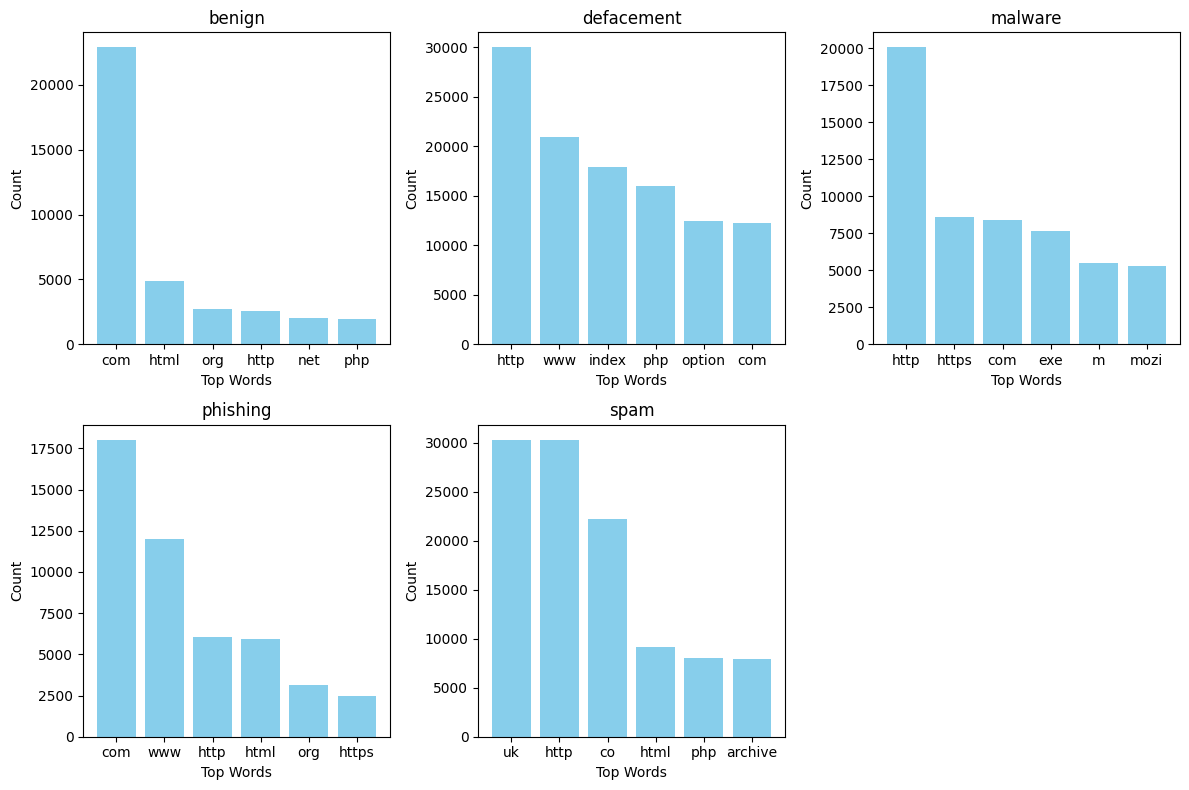

In [27]:
# Extracting data for plotting
top_words_per_type = {}
for idx, row in top_words_by_type['url'].items():
    type_name = top_words_by_type['type'][idx]
    top_words_per_type[type_name] = dict(row)

# Plotting bar graphs for each type
plt.figure(figsize=(12, 8))

for i, (type_name, top_words) in enumerate(top_words_per_type.items()):
    top_words = dict(sorted(top_words.items(), key=lambda x: x[1], reverse=True)[:6])  # Getting top 5 words
    plt.subplot(2, 3, i + 1)
    plt.bar(top_words.keys(), top_words.values(), color='skyblue')
    plt.title(type_name)
    plt.xlabel('Top Words')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Feature Extraction

In [28]:
df

,url,type,type_encoded,URL_Length,Domain,SpecialChars,Symbols,Chars,Numbers,Subdomains_Count,Path_Depth
343443,cybermuse.gallery.ca/cybermuse/search/artist_e...,benign,0,65,,9,9,52,4,NaN,NaN
193033,fanpix.net/gallery/paul-gleason-pictures.htm,benign,0,44,,6,6,38,0,NaN,NaN
376188,biogs.com/strictlycomedancing/bellingham.html,benign,0,45,,4,4,41,0,NaN,NaN
212737,mylife.com/c-1090135275,benign,0,23,,3,3,10,10,NaN,NaN
246981,mcshane-construction.com/leadership.aspx,benign,0,40,,4,4,36,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
414,http://archive.thisisyork.co.uk/2000/7/7/31515...,spam,4,52,archive.thisisyork.co.uk,11,11,29,12,NaN,NaN
1559,http://archive.thisisoxfordshire.co.uk/2005/11...,spam,4,60,archive.thisisoxfordshire.co.uk,11,11,36,13,NaN,NaN
4555,http://acard4u.co.uk/product_reviews_write.php...,spam,4,70,acard4u.co.uk,14,14,52,4,2.0,5.0
7184,http://archives.li.man.ac.uk/ead/search/?opera...,spam,4,213,archives.li.man.ac.uk,35,35,146,32,NaN,NaN


In [29]:
import pandas as pd
from urllib.parse import urlparse

# Function to extract features from URL
def extract_features(url):
    parsed_url = urlparse(url)
    
    features = {}
    
    # Domain Features
    domain = parsed_url.netloc
    features['domain_length'] = len(domain)
    features['subdomains_count'] = domain.count('.')
    features['special_chars_domain'] = sum(1 for char in domain if not char.isalnum())
    
    # Path Features
    path = parsed_url.path
    features['path_length'] = len(path)
    features['path_segments_count'] = path.count('/') + 1
    features['keywords_in_path'] = any(keyword in path.lower() for keyword in ['login', 'admin', 'malware'])
    
    # Query Features
    query = parsed_url.query
    features['has_query_params'] = bool(query)
    features['query_params_count'] = len(query.split('&')) if query else 0
    
    
    # Protocol Features
    features['uses_https'] = int(parsed_url.scheme == 'https')
    
    return features

# Apply the function to extract features and store them in new columns
extracted_features = df['url'].apply(extract_features).apply(pd.Series)

# Concatenate the extracted features with the original DataFrame
df = pd.concat([df, extracted_features], axis=1)



C:\Users\Aeiman Imtiaz\AppData\Local\Temp\ipykernel_13112\935817871.py:34: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  extracted_features = df['url'].apply(extract_features).apply(pd.Series)


In [30]:
df

,url,type,type_encoded,URL_Length,Domain,SpecialChars,Symbols,Chars,Numbers,Subdomains_Count,Path_Depth,domain_length,subdomains_count,special_chars_domain,path_length,path_segments_count,keywords_in_path,has_query_params,query_params_count,uses_https
343443,cybermuse.gallery.ca/cybermuse/search/artist_e...,benign,0,65,,9,9,52,4,NaN,NaN,0,0,0,50,4,False,True,1,0
193033,fanpix.net/gallery/paul-gleason-pictures.htm,benign,0,44,,6,6,38,0,NaN,NaN,0,0,0,44,3,False,False,0,0
376188,biogs.com/strictlycomedancing/bellingham.html,benign,0,45,,4,4,41,0,NaN,NaN,0,0,0,45,3,False,False,0,0
212737,mylife.com/c-1090135275,benign,0,23,,3,3,10,10,NaN,NaN,0,0,0,23,2,False,False,0,0
246981,mcshane-construction.com/leadership.aspx,benign,0,40,,4,4,36,0,NaN,NaN,0,0,0,40,2,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,http://archive.thisisyork.co.uk/2000/7/7/31515...,spam,4,52,archive.thisisyork.co.uk,11,11,29,12,NaN,NaN,24,3,3,21,5,False,False,0,0
1559,http://archive.thisisoxfordshire.co.uk/2005/11...,spam,4,60,archive.thisisoxfordshire.co.uk,11,11,36,13,NaN,NaN,31,3,3,22,5,False,False,0,0
4555,http://acard4u.co.uk/product_reviews_write.php...,spam,4,70,acard4u.co.uk,14,14,52,4,2.0,5.0,13,2,2,26,2,False,True,2,0
7184,http://archives.li.man.ac.uk/ead/search/?opera...,spam,4,213,archives.li.man.ac.uk,35,35,146,32,NaN,NaN,21,4,4,12,4,False,True,5,0


## Machine Learning

In [42]:
selected_columns = [ 'URL_Length','SpecialChars','Symbols','Chars','Numbers','domain_length','subdomains_count','path_length','path_segments_count','keywords_in_path','query_params_count','uses_https']  # Replace with the column names you want

# Create a new DataFrame 'new_df' using selected columns from 'df'

ml_df = df[selected_columns].copy()

In [43]:
ml_df

,URL_Length,SpecialChars,Symbols,Chars,Numbers,domain_length,subdomains_count,path_length,path_segments_count,keywords_in_path,query_params_count,uses_https
343443,65,9,9,52,4,0,0,50,4,False,1,0
193033,44,6,6,38,0,0,0,44,3,False,0,0
376188,45,4,4,41,0,0,0,45,3,False,0,0
212737,23,3,3,10,10,0,0,23,2,False,0,0
246981,40,4,4,36,0,0,0,40,2,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
414,52,11,11,29,12,24,3,21,5,False,0,0
1559,60,11,11,36,13,31,3,22,5,False,0,0
4555,70,14,14,52,4,13,2,26,2,False,2,0
7184,213,35,35,146,32,21,4,12,4,False,5,0


In [44]:
# List of categorical columns to be label encoded
categorical_columns = ['keywords_in_path']  # Replace with your columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Create a new DataFrame to store the encoded values
encoded_df = ml_df.copy()

# Apply label encoding for each categorical column
for column in categorical_columns:
    encoded_df[column + '_encoded'] = label_encoder.fit_transform(df[column])

# Drop original categorical columns if needed
encoded_df.drop(columns=categorical_columns, inplace=True)

In [45]:
encoded_df = encoded_df.fillna(0)
encoded_df

,URL_Length,SpecialChars,Symbols,Chars,Numbers,domain_length,subdomains_count,path_length,path_segments_count,query_params_count,uses_https,keywords_in_path_encoded
343443,65,9,9,52,4,0,0,50,4,1,0,0
193033,44,6,6,38,0,0,0,44,3,0,0,0
376188,45,4,4,41,0,0,0,45,3,0,0,0
212737,23,3,3,10,10,0,0,23,2,0,0,0
246981,40,4,4,36,0,0,0,40,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
414,52,11,11,29,12,24,3,21,5,0,0,0
1559,60,11,11,36,13,31,3,22,5,0,0,0
4555,70,14,14,52,4,13,2,26,2,2,0,0
7184,213,35,35,146,32,21,4,12,4,5,0,0


In [46]:
X = encoded_df
y = df['type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

In [47]:
warnings.filterwarnings('ignore')
# Initialize models

rf_model = RandomForestClassifier()

# Train models
rf_model.fit(X_train, y_train)

# Predictions
rf_preds = rf_model.predict(X_test)

# Calculate accuracies
rf_accuracy = accuracy_score(y_test, rf_preds)

print(f"Random Forest Accuracy: {rf_accuracy * 100}")

# Define the file name for the pickle file
pickle_file_name = "rf_model.pkl"

# Export the model to a pickle file
with open(pickle_file_name, 'wb') as file:
    pickle.dump(rf_model, file)

print("Model exported successfully to", pickle_file_name)

Random Forest Accuracy: 90.59666666666666
Model exported successfully to rf_model.pkl


### Gradient Boosting

In [48]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_preds)
print(f"Gradient Boosting Accuracy: {gb_accuracy * 100}")


# Define the file name for the pickle file
pickle_file_name = "gb_model.pkl"

# Export the model to a pickle file
with open(pickle_file_name, 'wb') as file:
    pickle.dump(gb_model, file)

print("Model exported successfully to", pickle_file_name)


Gradient Boosting Accuracy: 84.74333333333334
Model exported successfully to gb_model.pkl


### KNN

In [49]:

warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Make predictions
knn_preds = knn_model.predict(X_test)

pickle_file_name = "knn_model.pkl"

# Export the model to a pickle file
with open(pickle_file_name, 'wb') as file:
    pickle.dump(knn_model, file)

print("Model exported successfully to", pickle_file_name)

# Calculate accuracy
knn_accuracy = accuracy_score(y_test, knn_preds)
print(f"KNN Accuracy: {knn_accuracy * 100}")


Model exported successfully to knn_model.pkl
KNN Accuracy: 85.62666666666667


### Confusion Matrix

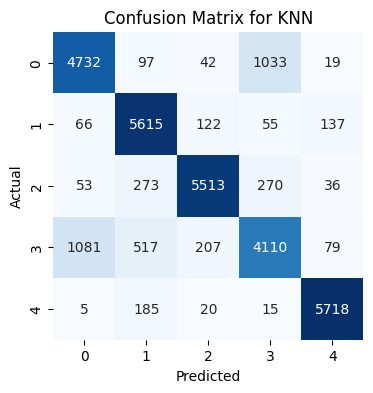

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Get the confusion matrix for a specific model (e.g., Random Forest)
conf_matrix = confusion_matrix(y_test, knn_preds)  # Change rf_preds to your model's predictions

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

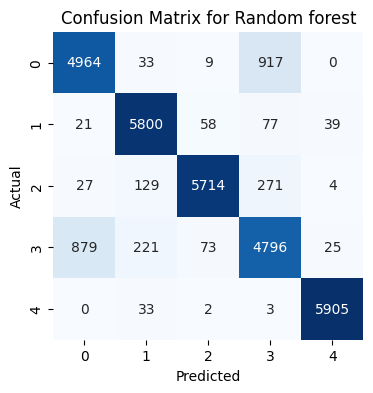

In [51]:

warnings.filterwarnings('ignore')

# Get the confusion matrix for a specific model (e.g., Random Forest)
conf_matrix = confusion_matrix(y_test, rf_preds)  # Change rf_preds to your model's predictions

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix for Random forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

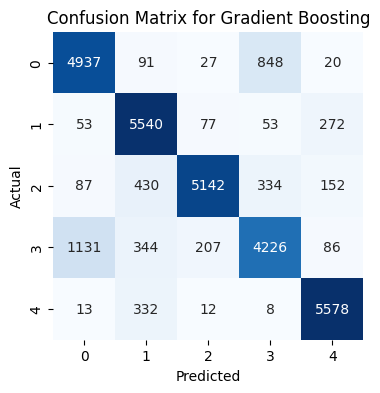

In [52]:

warnings.filterwarnings('ignore')

# Get the confusion matrix for a specific model (e.g., Random Forest)
conf_matrix = confusion_matrix(y_test, gb_preds)  # Change rf_preds to your model's predictions

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()